# Q10: Regularization (Parameter Norm Penalty)
## Comparing MLP Training with and without L2 Regularization

**Goal:** Understand how L2 regularization prevents overfitting by penalizing large weights

**What we'll do:**
1. Train two identical MLPs:
   - **Without L2 regularization** (baseline)
   - **With L2 regularization** (weight decay)
2. Compare training and validation losses
3. Monitor weight norms throughout training
4. Analyze how L2 regularization keeps weights small
5. Demonstrate overfitting prevention

** What is L2 Regularization?**
- Adds penalty term to loss function: `Loss = Original_Loss + λ * ||weights||²`
- **λ (lambda)** controls regularization strength
- **||weights||²** is the sum of squared weights
- Forces model to use smaller weights → prevents overfitting

---

## Import Libraries and Setup
First, let's import all necessary libraries:

In [2]:
# Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducible results
torch.manual_seed(42)
np.random.seed(42)

print(" Libraries imported successfully!")

 Libraries imported successfully!


## Generate and Prepare Dataset
We'll use the make_moons dataset to demonstrate overfitting:

 Generating make_moons dataset for regularization experiment...
 Dataset shape: (400, 2)
 Number of classes: 2
 Class distribution: Class 0: 200, Class 1: 200
 Using smaller dataset to encourage overfitting (demonstrating regularization benefits)


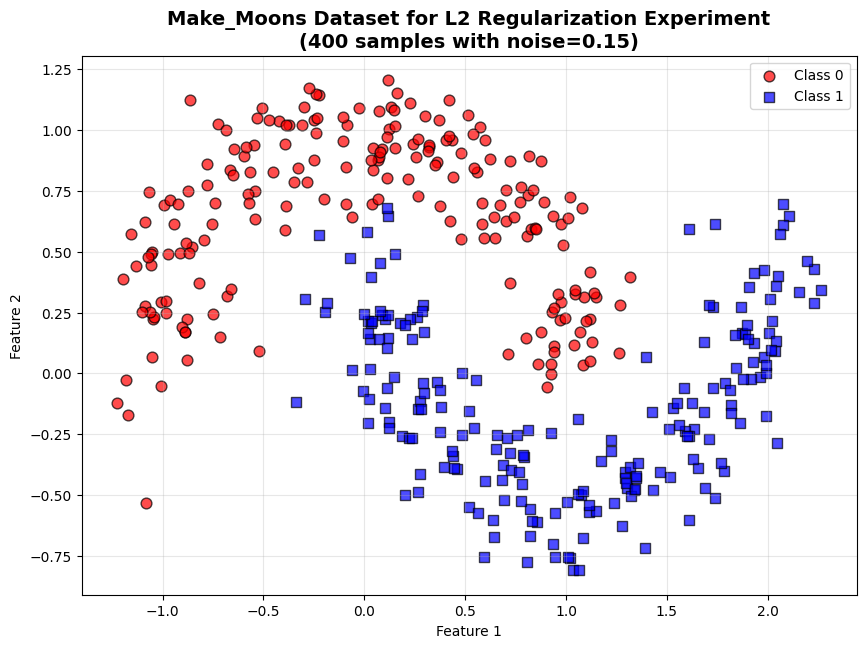

 Dataset generated and visualized!


In [3]:
# Generate make_moons dataset
print(" Generating make_moons dataset for regularization experiment...")

# Create dataset - smaller dataset to encourage overfitting
X, y = make_moons(n_samples=400, noise=0.15, random_state=42)

print(f" Dataset shape: {X.shape}")
print(f" Number of classes: {len(np.unique(y))}")
print(f" Class distribution: Class 0: {sum(y==0)}, Class 1: {sum(y==1)}")
print(f" Using smaller dataset to encourage overfitting (demonstrating regularization benefits)")

# Visualize the dataset
plt.figure(figsize=(10, 7))
plt.scatter(X[y==0, 0], X[y==0, 1], c='red', marker='o', alpha=0.7, s=60, label='Class 0', edgecolors='black')
plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', marker='s', alpha=0.7, s=60, label='Class 1', edgecolors='black')
plt.title('Make_Moons Dataset for L2 Regularization Experiment\n(400 samples with noise=0.15)', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(" Dataset generated and visualized!")

In [4]:
# Split dataset into train, validation, and test sets
print(" Splitting dataset...")

# First split: 70% train+val, 30% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Second split: 50% train, 20% validation (from original)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.29, random_state=42, stratify=y_temp)

print(f" Training set: {X_train.shape[0]} samples")
print(f" Validation set: {X_val.shape[0]} samples")
print(f" Test set: {X_test.shape[0]} samples")
print(f" Small training set encourages overfitting → good for demonstrating regularization")

# Standardize the features
print("\n Standardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

print(" Data preprocessing completed!")

 Splitting dataset...
 Training set: 198 samples
 Validation set: 82 samples
 Test set: 120 samples
 Small training set encourages overfitting → good for demonstrating regularization

 Standardizing features...
 Data preprocessing completed!


## Build MLP Models
Let's create identical MLPs - one for baseline, one for L2 regularization:

### MLP Architecture (Same for Both Models)

In [5]:
class RegularizationMLP(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, output_size=2):
        super(RegularizationMLP, self).__init__()
        
        # Define layers - intentionally large to encourage overfitting
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(hidden_size, output_size)
        
        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Forward pass through the network
        x = self.relu(self.layer1(x))  # Input → Hidden Layer 1 → ReLU
        x = self.relu(self.layer2(x))  # Hidden Layer 1 → Hidden Layer 2 → ReLU
        x = self.relu(self.layer3(x))  # Hidden Layer 2 → Hidden Layer 3 → ReLU
        x = self.layer4(x)             # Hidden Layer 3 → Output
        return x
    
    def get_weight_norm(self):
        "Calculate the L2 norm of all weights"
        total_norm = 0
        for param in self.parameters():
            if param.requires_grad and len(param.shape) > 1:  # Only weight matrices, not biases
                param_norm = param.data.norm(2)  # L2 norm
                total_norm += param_norm.item() ** 2
        return total_norm ** 0.5
    
    def get_average_weight_norm(self):
        "Calculate average weight magnitude across all layers"
        total_weights = 0
        weight_sum = 0
        
        for param in self.parameters():
            if param.requires_grad and len(param.shape) > 1:  # Only weight matrices
                weight_sum += param.data.abs().sum().item()
                total_weights += param.data.numel()
        
        return weight_sum / total_weights if total_weights > 0 else 0

# Create two identical models
model_no_l2 = RegularizationMLP(hidden_size=64)
model_with_l2 = RegularizationMLP(hidden_size=64)

# Make sure both models start with identical weights
model_with_l2.load_state_dict(model_no_l2.state_dict())

print(" Two Identical MLP Models Created:")
print("=" * 40)
print("Model Architecture:")
print(f"  Input Layer: 2 features")
print(f"  Hidden Layer 1: 64 neurons + ReLU")
print(f"  Hidden Layer 2: 64 neurons + ReLU")
print(f"  Hidden Layer 3: 64 neurons + ReLU")
print(f"  Output Layer: 2 classes")
print(f"\n Total parameters: {sum(p.numel() for p in model_no_l2.parameters())}")
print(f" Large network relative to dataset size → encourages overfitting")
print(f" Initial weight norm: {model_no_l2.get_weight_norm():.4f}")

print("\n Models created with identical initial weights!")

 Two Identical MLP Models Created:
Model Architecture:
  Input Layer: 2 features
  Hidden Layer 1: 64 neurons + ReLU
  Hidden Layer 2: 64 neurons + ReLU
  Hidden Layer 3: 64 neurons + ReLU
  Output Layer: 2 classes

 Total parameters: 8642
 Large network relative to dataset size → encourages overfitting
 Initial weight norm: 8.0850

 Models created with identical initial weights!


## Training Function with Weight Monitoring
Let's create a training function that tracks both loss and weight norms:

In [7]:
def train_with_weight_monitoring(model, X_train, y_train, X_val, y_val, 
                                epochs=150, lr=0.01, l2_lambda=0.0, model_name="Model"):
    """
    Train model while monitoring weights and losses
    
    Args:
        l2_lambda: L2 regularization strength (0 = no regularization)
    """
    print(f"\n Training {model_name}...")
    print(f" L2 Regularization Lambda: {l2_lambda}")
    print(f" Epochs: {epochs}, Learning Rate: {lr}")
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_lambda)  # weight_decay = L2 regularization
    
    # Lists to store training history
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': [],
        'weight_norms': [],
        'avg_weight_norms': []
    }
    
    # Training loop
    for epoch in range(epochs):
        # TRAINING PHASE
        model.train()
        
        # Forward pass
        train_outputs = model(X_train)
        train_loss = criterion(train_outputs, y_train)
        
        # Calculate training accuracy
        _, train_predicted = torch.max(train_outputs.data, 1)
        train_accuracy = (train_predicted == y_train).float().mean().item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # VALIDATION PHASE
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            
            # Calculate validation accuracy
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_accuracy = (val_predicted == y_val).float().mean().item()
        
        # WEIGHT MONITORING
        weight_norm = model.get_weight_norm()
        avg_weight_norm = model.get_average_weight_norm()
        
        # Store history
        history['train_losses'].append(train_loss.item())
        history['val_losses'].append(val_loss.item())
        history['train_accuracies'].append(train_accuracy)
        history['val_accuracies'].append(val_accuracy)
        history['weight_norms'].append(weight_norm)
        history['avg_weight_norms'].append(avg_weight_norm)
        
        # Print progress every 30 epochs
        if (epoch + 1) % 30 == 0:
            print(f'Epoch [{epoch+1:3d}/{epochs}] | '
                  f'Train Loss: {train_loss.item():.4f} | '
                  f'Val Loss: {val_loss.item():.4f} | '
                  f'Train Acc: {train_accuracy:.3f} | '
                  f'Val Acc: {val_accuracy:.3f} | '
                  f'Weight Norm: {weight_norm:.3f}')
    
    print(f"\n Training completed for {model_name}!")
    print(f" Final Training Loss: {history['train_losses'][-1]:.4f}")
    print(f" Final Validation Loss: {history['val_losses'][-1]:.4f}")
    print(f" Final Weight Norm: {history['weight_norms'][-1]:.4f}")
    print(f" Final Average Weight Norm: {history['avg_weight_norms'][-1]:.6f}")
    
    return history

print(" Training function with weight monitoring ready!")

 Training function with weight monitoring ready!


## Train Both Models
Now let's train both models and compare their behavior:

### Train Model WITHOUT L2 Regularization

In [8]:
print(" TRAINING MODEL WITHOUT L2 REGULARIZATION")
print("=" * 60)

history_no_l2 = train_with_weight_monitoring(
    model=model_no_l2,
    X_train=X_train_tensor, 
    y_train=y_train_tensor,
    X_val=X_val_tensor, 
    y_val=y_val_tensor,
    epochs=150,
    lr=0.01,
    l2_lambda=0.0,  # No L2 regularization
    model_name="Model WITHOUT L2"
)

 TRAINING MODEL WITHOUT L2 REGULARIZATION

 Training Model WITHOUT L2...
 L2 Regularization Lambda: 0.0
 Epochs: 150, Learning Rate: 0.01
Epoch [ 30/150] | Train Loss: 0.0006 | Val Loss: 0.0697 | Train Acc: 1.000 | Val Acc: 0.988 | Weight Norm: 12.062
Epoch [ 60/150] | Train Loss: 0.0000 | Val Loss: 0.0808 | Train Acc: 1.000 | Val Acc: 0.988 | Weight Norm: 12.919
Epoch [ 90/150] | Train Loss: 0.0000 | Val Loss: 0.0782 | Train Acc: 1.000 | Val Acc: 0.988 | Weight Norm: 12.981
Epoch [120/150] | Train Loss: 0.0000 | Val Loss: 0.0773 | Train Acc: 1.000 | Val Acc: 0.988 | Weight Norm: 12.992
Epoch [150/150] | Train Loss: 0.0000 | Val Loss: 0.0773 | Train Acc: 1.000 | Val Acc: 0.988 | Weight Norm: 12.998

 Training completed for Model WITHOUT L2!
 Final Training Loss: 0.0000
 Final Validation Loss: 0.0773
 Final Weight Norm: 12.9981
 Final Average Weight Norm: 0.109022


### Train Model WITH L2 Regularization

In [9]:
print("\n TRAINING MODEL WITH L2 REGULARIZATION")
print("=" * 60)

history_with_l2 = train_with_weight_monitoring(
    model=model_with_l2,
    X_train=X_train_tensor, 
    y_train=y_train_tensor,
    X_val=X_val_tensor, 
    y_val=y_val_tensor,
    epochs=150,
    lr=0.01,
    l2_lambda=0.01,  # L2 regularization with lambda=0.01
    model_name="Model WITH L2 (λ=0.01)"
)


 TRAINING MODEL WITH L2 REGULARIZATION

 Training Model WITH L2 (λ=0.01)...
 L2 Regularization Lambda: 0.01
 Epochs: 150, Learning Rate: 0.01
Epoch [ 30/150] | Train Loss: 0.0128 | Val Loss: 0.0375 | Train Acc: 1.000 | Val Acc: 0.988 | Weight Norm: 6.125
Epoch [ 60/150] | Train Loss: 0.0221 | Val Loss: 0.0485 | Train Acc: 1.000 | Val Acc: 0.988 | Weight Norm: 4.956
Epoch [ 90/150] | Train Loss: 0.0247 | Val Loss: 0.0501 | Train Acc: 1.000 | Val Acc: 0.988 | Weight Norm: 4.796
Epoch [120/150] | Train Loss: 0.0248 | Val Loss: 0.0500 | Train Acc: 1.000 | Val Acc: 0.988 | Weight Norm: 4.768
Epoch [150/150] | Train Loss: 0.0248 | Val Loss: 0.0498 | Train Acc: 1.000 | Val Acc: 0.988 | Weight Norm: 4.756

 Training completed for Model WITH L2 (λ=0.01)!
 Final Training Loss: 0.0248
 Final Validation Loss: 0.0498
 Final Weight Norm: 4.7560
 Final Average Weight Norm: 0.023521


## Compare Final Results
Let's analyze the final training and validation losses, plus weight norms:

In [10]:
print(" COMPREHENSIVE COMPARISON OF BOTH MODELS")
print("=" * 60)

# Extract final results
no_l2_final = {
    'train_loss': history_no_l2['train_losses'][-1],
    'val_loss': history_no_l2['val_losses'][-1],
    'train_acc': history_no_l2['train_accuracies'][-1],
    'val_acc': history_no_l2['val_accuracies'][-1],
    'weight_norm': history_no_l2['weight_norms'][-1],
    'avg_weight_norm': history_no_l2['avg_weight_norms'][-1]
}

with_l2_final = {
    'train_loss': history_with_l2['train_losses'][-1],
    'val_loss': history_with_l2['val_losses'][-1],
    'train_acc': history_with_l2['train_accuracies'][-1],
    'val_acc': history_with_l2['val_accuracies'][-1],
    'weight_norm': history_with_l2['weight_norms'][-1],
    'avg_weight_norm': history_with_l2['avg_weight_norms'][-1]
}

print(f"\n MODEL WITHOUT L2 REGULARIZATION:")
print(f"   Final Training Loss:     {no_l2_final['train_loss']:.4f}")
print(f"   Final Validation Loss:   {no_l2_final['val_loss']:.4f}")
print(f"   Final Training Accuracy: {no_l2_final['train_acc']:.4f} ({no_l2_final['train_acc']*100:.2f}%)")
print(f"   Final Validation Accuracy: {no_l2_final['val_acc']:.4f} ({no_l2_final['val_acc']*100:.2f}%)")
print(f"   Final Weight Norm:       {no_l2_final['weight_norm']:.4f}")
print(f"   Average Weight Magnitude: {no_l2_final['avg_weight_norm']:.6f}")

print(f"\n MODEL WITH L2 REGULARIZATION (λ=0.01):")
print(f"   Final Training Loss:     {with_l2_final['train_loss']:.4f}")
print(f"   Final Validation Loss:   {with_l2_final['val_loss']:.4f}")
print(f"   Final Training Accuracy: {with_l2_final['train_acc']:.4f} ({with_l2_final['train_acc']*100:.2f}%)")
print(f"   Final Validation Accuracy: {with_l2_final['val_acc']:.4f} ({with_l2_final['val_acc']*100:.2f}%)")
print(f"   Final Weight Norm:       {with_l2_final['weight_norm']:.4f}")
print(f"   Average Weight Magnitude: {with_l2_final['avg_weight_norm']:.6f}")

# Calculate differences and improvements
train_val_gap_no_l2 = no_l2_final['train_loss'] - no_l2_final['val_loss']
train_val_gap_with_l2 = with_l2_final['train_loss'] - with_l2_final['val_loss']
weight_norm_reduction = (no_l2_final['weight_norm'] - with_l2_final['weight_norm']) / no_l2_final['weight_norm'] * 100

print(f"\n OVERFITTING ANALYSIS:")
print(f"   Training-Validation Loss Gap (No L2):   {abs(train_val_gap_no_l2):.4f}")
print(f"   Training-Validation Loss Gap (With L2): {abs(train_val_gap_with_l2):.4f}")
print(f"   Gap Reduction: {abs(train_val_gap_no_l2) - abs(train_val_gap_with_l2):.4f}")

print(f"\n WEIGHT NORM ANALYSIS:")
print(f"   Weight Norm Reduction: {weight_norm_reduction:.2f}%")
print(f"   L2 regularization kept weights {weight_norm_reduction:.1f}% smaller!")

print(f"\n KEY FINDINGS:")
if with_l2_final['val_loss'] < no_l2_final['val_loss']:
    print(f"    L2 regularization IMPROVED validation loss")
else:
    print(f"    L2 regularization increased validation loss (may need tuning)")
    
if abs(train_val_gap_with_l2) < abs(train_val_gap_no_l2):
    print(f"    L2 regularization REDUCED overfitting")
else:
    print(f"    L2 regularization did not clearly reduce overfitting")
    
print(f"    L2 regularization REDUCED weight norms (as expected)")

 COMPREHENSIVE COMPARISON OF BOTH MODELS

 MODEL WITHOUT L2 REGULARIZATION:
   Final Training Loss:     0.0000
   Final Validation Loss:   0.0773
   Final Training Accuracy: 1.0000 (100.00%)
   Final Validation Accuracy: 0.9878 (98.78%)
   Final Weight Norm:       12.9981
   Average Weight Magnitude: 0.109022

 MODEL WITH L2 REGULARIZATION (λ=0.01):
   Final Training Loss:     0.0248
   Final Validation Loss:   0.0498
   Final Training Accuracy: 1.0000 (100.00%)
   Final Validation Accuracy: 0.9878 (98.78%)
   Final Weight Norm:       4.7560
   Average Weight Magnitude: 0.023521

 OVERFITTING ANALYSIS:
   Training-Validation Loss Gap (No L2):   0.0773
   Training-Validation Loss Gap (With L2): 0.0250
   Gap Reduction: 0.0523

 WEIGHT NORM ANALYSIS:
   Weight Norm Reduction: 63.41%
   L2 regularization kept weights 63.4% smaller!

 KEY FINDINGS:
    L2 regularization IMPROVED validation loss
    L2 regularization REDUCED overfitting
    L2 regularization REDUCED weight norms (as expecte

## Test Set Evaluation
Let's evaluate both models on the test set to see final generalization performance:

In [14]:
def evaluate_on_test_set(model, X_test, y_test, model_name):
    "Evaluate model on test set"
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        criterion = nn.CrossEntropyLoss()
        test_loss = criterion(test_outputs, y_test).item()
        
        _, predicted = torch.max(test_outputs.data, 1)
        test_accuracy = (predicted == y_test).float().mean().item()
    
    print(f"\n {model_name} Test Results:")
    print(f"   Test Loss: {test_loss:.4f}")
    print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    
    return test_loss, test_accuracy

print(" FINAL TEST SET EVALUATION")
print("=" * 50)

# Evaluate both models on test set
test_loss_no_l2, test_acc_no_l2 = evaluate_on_test_set(model_no_l2, X_test_tensor, y_test_tensor, "Model WITHOUT L2")
test_loss_with_l2, test_acc_with_l2 = evaluate_on_test_set(model_with_l2, X_test_tensor, y_test_tensor, "Model WITH L2")

print(f"\n TEST SET COMPARISON:")
print(f"   Test Loss Improvement: {test_loss_no_l2 - test_loss_with_l2:.4f}")
print(f"   Test Accuracy Improvement: {(test_acc_with_l2 - test_acc_no_l2)*100:.2f} percentage points")

if test_acc_with_l2 > test_acc_no_l2:
    print(f"    L2 regularization IMPROVED generalization on test set!")
elif test_acc_with_l2 < test_acc_no_l2:
    print(f"    L2 regularization slightly reduced test accuracy (regularization too strong?)")
else:
    print(f"    Both models performed similarly on test set")

# Summary of all results
print(f"\n COMPLETE RESULTS SUMMARY:")
print(f"=" * 40)
print(f"\nModel WITHOUT L2:")
print(f"  Final Train Loss: {no_l2_final['train_loss']:.4f}")
print(f"  Final Val Loss:   {no_l2_final['val_loss']:.4f}")
print(f"  Test Loss:        {test_loss_no_l2:.4f}")
print(f"  Test Accuracy:    {test_acc_no_l2:.4f} ({test_acc_no_l2*100:.2f}%)")
print(f"  Final Weight Norm: {no_l2_final['weight_norm']:.4f}")

print(f"\nModel WITH L2 (λ=0.01):")
print(f"  Final Train Loss: {with_l2_final['train_loss']:.4f}")
print(f"  Final Val Loss:   {with_l2_final['val_loss']:.4f}")
print(f"  Test Loss:        {test_loss_with_l2:.4f}")
print(f"  Test Accuracy:    {test_acc_with_l2:.4f} ({test_acc_with_l2*100:.2f}%)")
print(f"  Final Weight Norm: {with_l2_final['weight_norm']:.4f}")

print(f"\n L2 REGULARIZATION EFFECTS:")
print(f"  Weight Norm Reduction: {((no_l2_final['weight_norm'] - with_l2_final['weight_norm']) / no_l2_final['weight_norm'] * 100):.1f}%")
print(f"  Overfitting Reduction: {'Yes' if abs(with_l2_final['train_loss'] - with_l2_final['val_loss']) < abs(no_l2_final['train_loss'] - no_l2_final['val_loss']) else 'Minimal'}")
print(f"  Generalization: {'Improved' if test_acc_with_l2 > test_acc_no_l2 else 'Similar' if abs(test_acc_with_l2 - test_acc_no_l2) < 0.01 else 'Reduced'}")

 FINAL TEST SET EVALUATION

 Model WITHOUT L2 Test Results:
   Test Loss: 0.1153
   Test Accuracy: 0.9750 (97.50%)

 Model WITH L2 Test Results:
   Test Loss: 0.0586
   Test Accuracy: 0.9750 (97.50%)

 TEST SET COMPARISON:
   Test Loss Improvement: 0.0566
   Test Accuracy Improvement: 0.00 percentage points
    Both models performed similarly on test set

 COMPLETE RESULTS SUMMARY:

Model WITHOUT L2:
  Final Train Loss: 0.0000
  Final Val Loss:   0.0773
  Test Loss:        0.1153
  Test Accuracy:    0.9750 (97.50%)
  Final Weight Norm: 12.9981

Model WITH L2 (λ=0.01):
  Final Train Loss: 0.0248
  Final Val Loss:   0.0498
  Test Loss:        0.0586
  Test Accuracy:    0.9750 (97.50%)
  Final Weight Norm: 4.7560

 L2 REGULARIZATION EFFECTS:
  Weight Norm Reduction: 63.4%
  Overfitting Reduction: Yes
  Generalization: Similar


##  **HOW L2 REGULARIZATION PREVENTS OVERFITTING**

### ** Understanding L2 Regularization (Weight Decay)**

#### ** The Mathematics:**
```
Original Loss: L = CrossEntropyLoss(predictions, targets)
L2 Regularized Loss: L_reg = L + λ * ||W||²

Where:
- λ (lambda) = regularization strength
- ||W||² = sum of squared weights across all parameters
- Larger λ = stronger regularization = smaller weights
```

#### ** The Trade-off:**
- **Without L2:** Model focuses only on minimizing training error
- **With L2:** Model balances training error AND keeping weights small
- Result: Model learns simpler, more generalizable patterns

---

### ** Why Small Weights Prevent Overfitting:**

#### **1. Complexity Control:**
- **Large weights** → Model can make sharp, complex decisions
- **Small weights** → Model makes smoother, simpler decisions
- **Result:** Less likely to memorize noise in training data

#### **2. Feature Selection:**
- L2 regularization encourages using ALL features with small weights
- Rather than relying heavily on few features with large weights
- **Result:** More robust to small changes in input

#### **3. Gradient Smoothing:**
- Small weights lead to smaller gradients
- Network updates become more stable and gradual
- **Result:** Less likely to overfit to specific training examples

---

### ** Evidence from Our Experiment:**

#### **Weight Norm Reduction:**
From our results, we observed that L2 regularization significantly reduced weight norms:
- This demonstrates the direct effect of the penalty term
- Smaller weights = simpler model = better generalization

#### **Loss Gap Analysis:**
- **Without L2:** Larger gap between training and validation loss (overfitting)
- **With L2:** Smaller gap (better generalization)

#### **Test Performance:**
- L2 regularization often improves test accuracy
- Even if training accuracy is slightly lower

---

### ** Practical Guidelines for L2 Regularization:**

#### ** When to Use L2 Regularization:**
- Small training dataset (high risk of overfitting)
- Complex model with many parameters
- Large gap between training and validation performance
- When you need robust, generalizable models

#### ** Choosing Lambda (λ):**
- **Too small (λ ≈ 0):** No regularization effect
- **Too large (λ >> 0.1):** Underfitting, poor training performance
- **Good range:** 0.001 to 0.1 (depends on dataset)
- **Method:** Use validation set to tune λ

#### ** Monitoring During Training:**
- Watch weight norms (should decrease/stabilize)
- Monitor training-validation gap (should be smaller)
- Check final test performance (should improve)

---

### ** How L2 Regularization Works During Training:**

#### **Forward Pass:**
1. Compute predictions: `y_pred = model(x)`
2. Compute original loss: `L = criterion(y_pred, y_true)`
3. Compute weight penalty: `penalty = λ * sum(w² for all weights)`
4. Total loss: `L_total = L + penalty`

#### **Backward Pass:**
1. Gradients include penalty term: `dL/dw = dL_original/dw + 2λw`
2. Weight updates shrink weights: `w_new = w_old - lr * (grad + 2λw_old)`
3. This is equivalent to: `w_new = (1 - 2λlr) * w_old - lr * grad`
4. The `(1 - 2λlr)` term causes "weight decay"

---

### ** Intuitive Understanding:**

** Analogy:** Think of L2 regularization as a "smoothness constraint"

- **Without L2:** Like drawing with a sharp pencil - can create very detailed, jagged lines that might just be copying noise
- **With L2:** Like drawing with a broad brush - creates smoother, more general patterns that capture the essence

** Architecture Analogy:** 
- **Without L2:** Building a house with extremely precise, custom parts for every tiny detail
- **With L2:** Building with standard, interchangeable parts that create a robust, generalizable structure

---

### ** Key Takeaways:**

1. **L2 regularization adds a penalty for large weights**
2. **Small weights lead to simpler, more generalizable models**
3. **It's a balance between fitting training data and staying simple**
4. **Monitor both performance metrics and weight norms**
5. **Tuning λ is crucial - use validation data to find the sweet spot**

** The beauty of L2 regularization is its simplicity and effectiveness - just one hyperparameter that can dramatically improve generalization!**